In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc
import pickle

from keras.models import Sequential
from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['predmolprop-featureengineering-finaltrain', 'champs-scalar-coupling', 'predmolprop-featureengineering-finaltest']


In [2]:
dtypes = {'atom_index_0':'uint8', 
          'atom_index_1':'uint8', 
          'scalar_coupling_constant':'float32', 
          'num_C':'uint8', 
          'num_H':'uint8', 
          'num_N':'uint8', 
          'num_O':'uint8', 
          'num_F':'uint8',
          'total_atoms':'uint8',
          'num_bonds':'uint8', 
          'num_mol_bonds':'uint8', 
          'min_d':'float32', 
          'mean_d':'float32', 
          'max_d':'float32', 
          'space_dr':'float32', 
          'bond_dr':'float32',
          'bond_1':'uint8', 
          'bond_2':'uint8', 
          'bond_3':'uint8', 
          'atom_0_pc':'float32', 
          'atom_end_pc':'float32',
          'atom_2_hyb':'uint8', 
          'atom_3_hyb':'uint8', 
          'atom_end_hyb':'uint8', 
          'path_count':'uint8', 
          'atom_0_min':'float32',
          'atom_0_mean':'float32', 
          'atom_0_max':'float32', 
          'atom_0_Cmin':'float32', 
          'atom_0_Cmean':'float32',
          'atom_0_Cmax':'float32', 
          'atom_0_Omin':'float32', 
          'atom_0_Omean':'float32',
          'atom_0_Omax':'float32', 
          'atom_0_Nmin':'float32', 
          'atom_0_Nmean':'float32', 
          'atom_0_Nmax':'float32',
          'atom_0_Fmin':'float32', 
          'atom_0_Fmean':'float32', 
          'atom_0_Fmax':'float32', 
          'atom_end_min':'float32',
          'atom_end_mean':'float32', 
          'atom_end_max':'float32', 
          'atom_end_Cmin':'float32', 
          'atom_end_Cmean':'float32',
          'atom_end_Cmax':'float32', 
          'atom_end_Omin':'float32', 
          'atom_end_Omean':'float32',
          'atom_end_Omax':'float32', 
          'atom_end_Nmin':'float32', 
          'atom_end_Nmean':'float32', 
          'atom_end_Nmax':'float32',
          'atom_end_Fmin':'float32', 
          'atom_end_Fmean':'float32', 
          'atom_end_Fmax':'float32',
          'Dmin_COM':'float32', 
          'Dmean_COM':'float32', 
          'Dmax_COM':'float32',
          'COM_dr_0': 'float32',
          'COM_dr_1': 'float32',
          'bond2_angle': 'float32',
          'bond3_angle': 'float32'
         }

In [3]:
train = pd.read_csv("../input/predmolprop-featureengineering-finaltrain/train_extend.csv",dtype=dtypes)
test = pd.read_csv("../input/predmolprop-featureengineering-finaltest/test_extend.csv",dtype=dtypes)

In [4]:
PopList = ['molecule_name', 'atom_index_0','atom_index_1','num_bonds','atom_end_type',
           'bond_1','is_linear','atom_2_hyb','atom_3_hyb','atom_end_hyb',
           'atom_0_fc', 'atom_end_fc','atom_0_val','atom_end_val','atom_0_sm', 'atom_end_sm']

for col in PopList:
    if col in train:
        train.pop(col)
        test.pop(col)
    
train.fillna(value ='',inplace= True)
test.fillna(value='',inplace=True)

coupling_types = sorted(list(train.type.unique()))
gc.collect()

33

In [5]:
# Encode categorical features
from sklearn.preprocessing import LabelEncoder

cols = ['atom_0_type2','atom_2_type','atom_3_type','atom_end_type2']
for col in cols:
    enc = LabelEncoder()
    train[col]=enc.fit_transform(train[col]).astype(np.uint8)
    test[col]=enc.transform(test[col]).astype(np.uint8)
del cols

In [6]:
train.columns

Index(['id', 'type', 'scalar_coupling_constant', 'num_mol_bonds', 'min_d',
       'mean_d', 'max_d', 'space_dr', 'bond_dr', 'bond_2', 'bond_3',
       'atom_0_pc', 'atom_end_pc', 'atom_0_type2', 'atom_2_type',
       'atom_3_type', 'atom_end_type2', 'path_count', 'atom_0_min',
       'atom_0_mean', 'atom_0_max', 'atom_0_Cmin', 'atom_0_Cmean',
       'atom_0_Cmax', 'atom_0_Omin', 'atom_0_Omean', 'atom_0_Omax',
       'atom_0_Nmin', 'atom_0_Nmean', 'atom_0_Nmax', 'atom_0_Fmin',
       'atom_0_Fmean', 'atom_0_Fmax', 'atom_end_min', 'atom_end_mean',
       'atom_end_max', 'atom_end_Cmin', 'atom_end_Cmean', 'atom_end_Cmax',
       'atom_end_Omin', 'atom_end_Omean', 'atom_end_Omax', 'atom_end_Nmin',
       'atom_end_Nmean', 'atom_end_Nmax', 'atom_end_Fmin', 'atom_end_Fmean',
       'atom_end_Fmax', 'bond2_angle', 'bond3_angle', 'COM_dr_0', 'COM_dr_1',
       'num_C', 'num_H', 'num_N', 'num_O', 'num_F', 'total_atoms', 'Dmin_COM',
       'Dmean_COM', 'Dmax_COM'],
      dtype='object')

In [7]:
train.head()

,id,type,scalar_coupling_constant,num_mol_bonds,min_d,mean_d,max_d,space_dr,bond_dr,bond_2,...,COM_dr_1,num_C,num_H,num_N,num_O,num_F,total_atoms,Dmin_COM,Dmean_COM,Dmax_COM
0,0,1JHC,84.807602,4,1.091946,1.506668,1.783158,1.091953,1.091953,255,...,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954
1,1,2JHH,-11.257000,4,1.091946,1.506668,1.783158,1.783120,2.183905,1,...,1.091946,1,4,0,0,0,5,0.000012,0.873562,1.091954
2,2,2JHH,-11.254800,4,1.091946,1.506668,1.783158,1.783147,2.183899,1,...,1.091954,1,4,0,0,0,5,0.000012,0.873562,1.091954
3,3,2JHH,-11.254300,4,1.091946,1.506668,1.783158,1.783157,2.183901,1,...,1.091954,1,4,0,0,0,5,0.000012,0.873562,1.091954
4,4,1JHC,84.807404,4,1.091946,1.506668,1.783158,1.091952,1.091952,255,...,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954


In [8]:
# feature lists
prefix_train= ['id', 'type', 'scalar_coupling_constant']
prefix_test= ['id', 'type']

fc_distance = ['space_dr','bond_dr','min_d','mean_d', 'max_d']

fc_COM = ['Dmin_COM', 'Dmean_COM', 'Dmax_COM']

fc_size = ['num_mol_bonds', 'total_atoms','num_C', 'num_H', 'num_N', 'num_O', 'num_F']

fc_atom_0 = ['atom_0_pc','atom_0_type2','COM_dr_0',
             'atom_0_min','atom_0_mean', 'atom_0_max',
             'atom_0_Cmin', 'atom_0_Cmean','atom_0_Cmax',
             'atom_0_Nmin', 'atom_0_Nmean', 'atom_0_Nmax',
             'atom_0_Omin', 'atom_0_Omean','atom_0_Omax',
             'atom_0_Fmin', 'atom_0_Fmean', 'atom_0_Fmax']

fc_atom_end = ['atom_end_pc', 'atom_end_type2', 'COM_dr_1',
               'atom_end_min','atom_end_mean', 'atom_end_max',
               'atom_end_Cmin', 'atom_end_Cmean','atom_end_Cmax',
               'atom_end_Nmin', 'atom_end_Nmean', 'atom_end_Nmax',
               'atom_end_Omin', 'atom_end_Omean','atom_end_Omax',
               'atom_end_Fmin', 'atom_end_Fmean', 'atom_end_Fmax']

fc_2 = ['path_count','atom_2_type','bond_2','bond2_angle']
fc_3 = ['atom_3_type','bond_3','bond3_angle']

fc1 = set(fc_distance+fc_COM+fc_size+fc_atom_0+fc_atom_end)

# reorder
train = train[prefix_train+fc_distance+fc_COM+fc_size+fc_atom_0+fc_atom_end+fc_2+fc_3]
test = test[prefix_test+fc_distance+fc_COM+fc_size+fc_atom_0+fc_atom_end+fc_2+fc_3]
len(train.columns)

61

In [9]:
# Process Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
def ProcessData(df,features,test_size=0.25):
    scaler = StandardScaler()
    features = sorted(list(features))
    if test_size == 0:
        train_Y = df.pop('scalar_coupling_constant')
        train_type = df.pop('type')
        df.pop('id')
        train_X[features] = scaler.fit_transform(df[features])
        return train_X, train_Y, train_type, scaler
        #return df.loc[:,df.columns.map(lambda x: x in features)], train_Y, train_type
    
    train_X, val_X, train_Y, val_Y = train_test_split(df[features+['type']], 
                                                      df.scalar_coupling_constant,test_size=test_size,random_state=42)
    
    train_type = train_X.pop('type')
    val_type = val_X.pop('type')
    scaler.fit(train_X)#.append(val_X))
    train_X[train_X.columns] = scaler.transform(train_X[train_X.columns])
    val_X[val_X.columns] = scaler.transform(val_X[val_X.columns])
    return train_X, train_Y, train_type, val_X, val_Y, val_type, scaler

In [10]:
def CalcLMAE(y_true, y_pred, groups, floor=1e-9):
    maes = (y_true-y_pred).abs().groupby(groups).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [11]:
def BuildKerasModel(input_shape,hidden_units=[1024,128,4],dropout_rate=0.2,lr=0.001,beta1=0.9,beta2=0.999):
    model=Sequential()
    model.add(Dense(hidden_units[0], activation = 'relu', input_shape=input_shape))
    #model.add(BatchNormalization())
    if(dropout_rate>0):
        model.add(Dropout(rate=dropout_rate))
    for units in hidden_units[1:]:
        model.add(Dense(units, activation = 'relu'))
        #model.add(BatchNormalization())
        if(dropout_rate>0):
            model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', 
                  optimizer=Adam(learning_rate=lr, beta_1=beta1, beta_2=beta2))
    return model

In [12]:
def plot_history(history, label):
    for key in sorted(history.history.keys()):
        plt.plot(history.history[key])
        
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(list(sorted(history.history.keys())), loc='upper left')
    plt.show()

In [13]:
def SingleRun(df,features,hidden_units=[1024,512,128],dropout=0.2,lr=0.001,beta1=0.9,beta2=0.999,
              test_size=0.25,includeType=False,DoCallbacks=False,**kwargs):
    data = ProcessData(df,features,test_size)
    if(test_size==0):
        train_X,train_Y,train_type,scaler = data
    else:
        train_X,train_Y,train_type,val_X,val_Y,val_type,scaler = data
    if includeType:
        train_X=train_X.join(train_type)
        val_X=val_X.join(val_type)
        enc = LabelEncoder()
        train_X.type=enc.fit_transform(train_X.type).astype(np.uint8)
        val_X.type=enc.transform(val_X.type).astype(np.uint8)
    
    model=BuildKerasModel((len(features),),hidden_units=hidden_units,dropout_rate=dropout,lr=lr,beta1=beta1,beta2=beta2)
    
    t1=time.time()
    if DoCallbacks:
        if test_size==0:
            print('ERROR: need test data for early_stopping_rounds')
            return -1,-1,-1
    
        # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
        es = callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20,verbose=1, 
                                     mode='min', restore_best_weights=True)
        # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
        rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=10, 
                                          min_lr=1e-6, mode='min', verbose=1)

        history=model.fit(x=train_X, y=train_Y, callbacks=[rlr,es], validation_data=(val_X,val_Y), **kwargs)
    else:
        if test_size==0:
            history=model.fit(x=train_X, y=train_Y, **kwargs)
        else:
            history=model.fit(x=train_X, y=train_Y, validation_data=(val_X,val_Y), **kwargs)
    
    plot_history(history, train_type.values[0])
        
    t2=time.time()
    print('training time:',t2-t1)
    train_predict = pd.Series(model.predict(train_X).flatten(),
                              index=train_X.index)
    train_LMAE = CalcLMAE(train_Y,train_predict,train_type)
    print('\ttrain LMAE:',train_LMAE)
    if(test_size==0):
        val_LMAE = None
        plt.figure(figsize=[6,6])
        sns.scatterplot(x=train_Y, y=train_predict)
        plt.plot(val_Y,val_Y,color='black')
        plt.title(train_type.values[0])
        plt.xlabel('scalar coupling constant')
        plt.ylabel('predicted value')
#        lims = plt.xlim()
#        width=lims[1]-lims[0]
#        lims=lims[0]-0.01*width,lims[1]+0.01*width
#        plt.xlim(lims)
#        plt.ylim(lims)
        plt.show()
    else:
        val_predict = pd.Series(model.predict(val_X).flatten(),index=val_X.index)
        val_LMAE = CalcLMAE(val_Y,val_predict,val_type)
        print('\tval LMAE:',val_LMAE)
        plt.figure(figsize=[6,6])
        sns.scatterplot(x=val_Y, y=val_predict)
        plt.plot(val_Y,val_Y,color='black')
        plt.title(train_type.values[0])
        plt.xlabel('scalar coupling constant')
        plt.ylabel('predicted value')
#        lims = plt.xlim()
#        width=lims[1]-lims[0]
#        lims=lims[0]-0.01*width,lims[1]+0.01*width
#        plt.xlim(lims)
#        plt.ylim(lims)
        plt.show()
        
    gc.collect()
    return model, train_LMAE, val_LMAE, scaler

Jtype = '2JHN'
train_sample = train[train.type==Jtype].sample(10000)
features=fc1.copy()
features.update(fc_2)
#features.update(fc_2[:-1]+fc_3)

model, train_LMAE, val_LMAE, scaler = SingleRun(train_sample,features,
                                                hidden_units=[128,512,128,64,32],
                                                dropout=0,lr=0.001,beta1=0.9,beta2=0.999,
                                                test_size=0.2,includeType=False,DoCallbacks=True,# end of params, start kwargs,
                                                batch_size=128, epochs=200, verbose=0,shuffle=True,
                                                validation_steps=None, validation_freq=1)

#model.save('model_'+Jtype)
#pickle.dump(scaler,'scaler_'+Jtype)

**RUN BY TYPE**

In [14]:
def RunByType(df,hidden_units=[1024,512,128],dropout=0,lr=0.001,beta1=0.9,beta2=0.999,
              test_size=0.25,includeType=False,DoCallbacks=False,**kwargs):
    model_dict={}
    train_LMAE_dict={}
    val_LMAE_dict={}
    scaler_dict={}
    for coupling_type in coupling_types:
        print('Now training type:',str(coupling_type))

        df_type = df[df['type']==coupling_type]

        features=fc1.copy()
        if(coupling_type[0]=='2'):
            features.update(fc_2)
        elif(coupling_type[0]=='3'):
            features.update(fc_2[:-1]+fc_3)
        
        model,train_LMAE,val_LMAE,scaler = SingleRun(df_type,features,
                                              hidden_units=hidden_units,dropout=dropout,lr=lr,beta1=beta1,beta2=beta2,
                                              test_size=test_size,includeType=includeType,
                                              DoCallbacks=DoCallbacks,**kwargs)

        model_dict[coupling_type]=model
        train_LMAE_dict[coupling_type]=train_LMAE
        val_LMAE_dict[coupling_type]=val_LMAE
        scaler_dict[coupling_type]=scaler
        
    train_LMAE = sum(train_LMAE_dict.values())/len(coupling_types)
    if test_size>0:
        val_LMAE = sum(val_LMAE_dict.values())/len(coupling_types)
    else:
        val_LMAE=None
    print('total train LMAE:',train_LMAE)
    print('total val LMAE', val_LMAE)
    gc.collect()
    return model_dict, scaler_dict#,train_LMAE, val_LMAE


In [15]:
def PredictByType(df_X,model_dict,scaler_dict,df_Y=None):
    predictions = pd.DataFrame()

    for coupling_type in coupling_types:
        print('predicting type:',str(coupling_type))
        model = model_dict[coupling_type]
        scaler = scaler_dict[coupling_type]
        df_type = df_X[df_X['type']==coupling_type]
        
        features=fc1.copy()
        if(coupling_type[0]=='2'):
            features.update(fc_2)
        elif(coupling_type[0]=='3'):
            features.update(fc_2[:-1]+fc_3)
        
        features = sorted(list(features))
        predict = model.predict(scaler.transform(df_type[features])).flatten()
        predict = pd.Series(predict,index=df_type.index)
        predict = pd.DataFrame({'id':df_type.id,'scalar_coupling_constant': predict})
        predict.set_index('id',inplace=True)
        predictions = pd.concat([predictions,predict])
    
    if df_Y is not None:
        predictions.columns = ['predictions']
        merged = pd.merge(train,predictions,how='left',left_on='id',right_index=True)
        LMAE = CalcLMAE(df_Y, merged.predictions,merged.type)
        print('LMAE:', LMAE)
        g = sns.FacetGrid(merged,col="type", col_order = coupling_types,sharex=False,sharey=False)
        g.map(sns.scatterplot, "scalar_coupling_constant","predictions")
        del merged
    
    gc.collect()
    return predictions


Now training type: 1JHC

Epoch 00090: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00141: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00154: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00169: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00179: early stopping


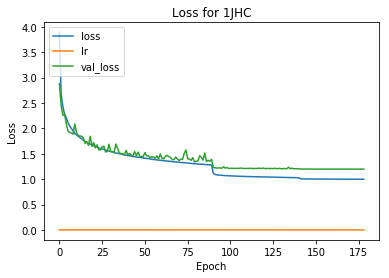

training time: 3571.940700531006
	train LMAE: -0.0017584516797192157
	val LMAE: 0.17985927996989348


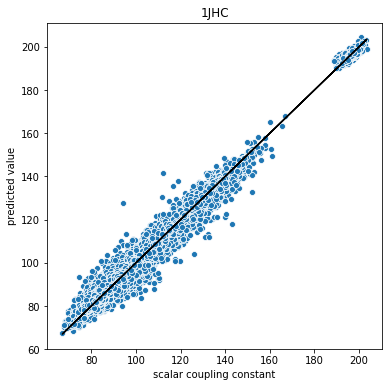

Now training type: 1JHN

Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00102: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00115: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00132: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00142: early stopping


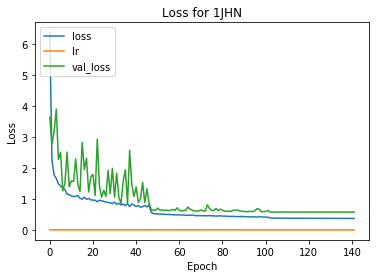

training time: 165.42319774627686
	train LMAE: -0.9881054929100618
	val LMAE: -0.5523215450339756


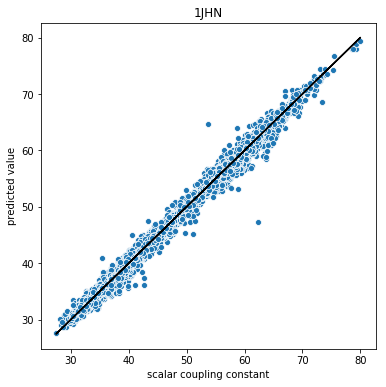

Now training type: 2JHC

Epoch 00082: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00103: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00114: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00124: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00124: early stopping


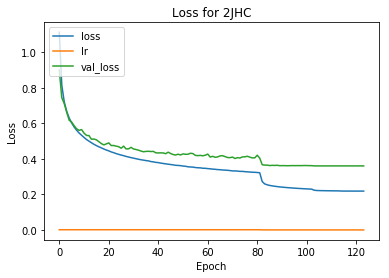

training time: 3791.8733537197113
	train LMAE: -1.5078223865927438
	val LMAE: -1.0214330123833129


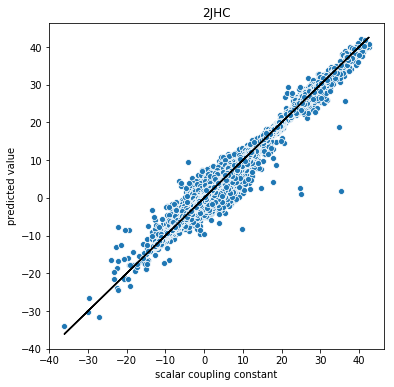

Now training type: 2JHH

Epoch 00114: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00130: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00141: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00151: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00151: early stopping


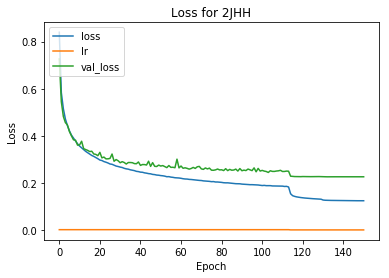

training time: 1552.4682412147522
	train LMAE: -2.072489753038326
	val LMAE: -1.4885924086221816


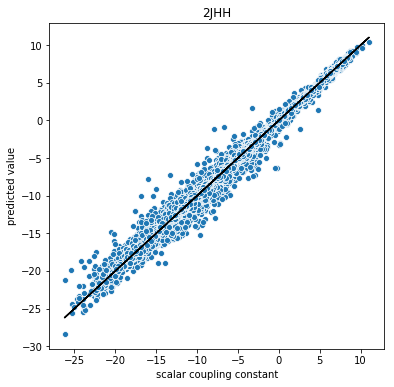

Now training type: 2JHN

Epoch 00151: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00178: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00188: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00188: early stopping


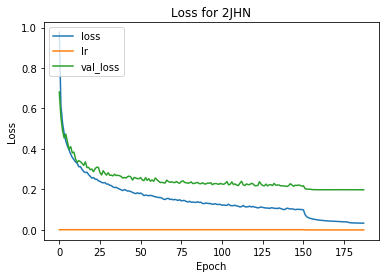

training time: 612.6744940280914
	train LMAE: -3.1758997156764472
	val LMAE: -1.6181093422560213


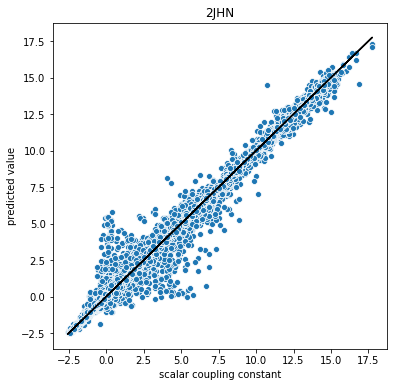

Now training type: 3JHC

Epoch 00148: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00187: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00187: early stopping


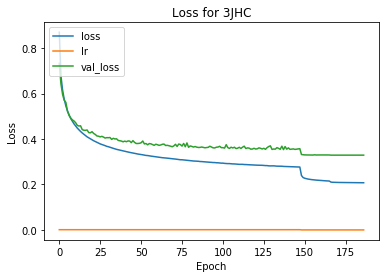

training time: 7603.329889535904
	train LMAE: -1.563910988610431
	val LMAE: -1.1115846778095426


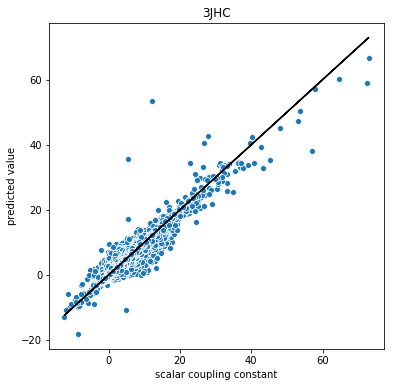

Now training type: 3JHH

Epoch 00091: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00115: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00126: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00136: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00136: early stopping


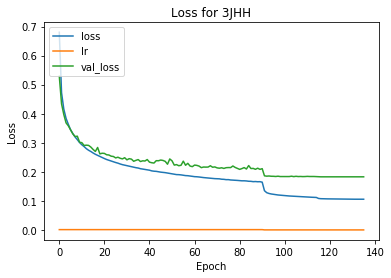

training time: 2215.9896841049194
	train LMAE: -2.232163099276281
	val LMAE: -1.6992407883165173


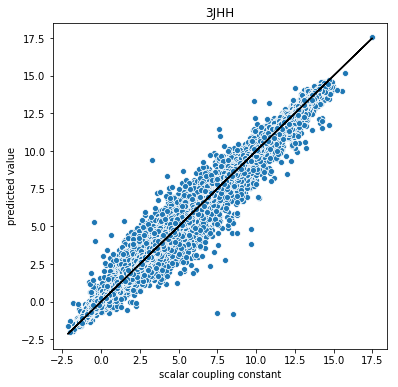

Now training type: 3JHN

Epoch 00090: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00115: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00125: early stopping


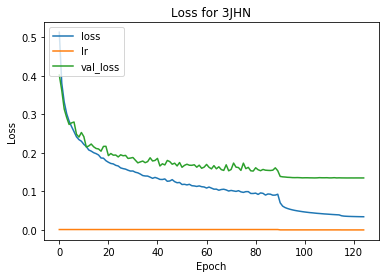

training time: 566.1378858089447
	train LMAE: -3.162341940445792
	val LMAE: -2.002510705101706


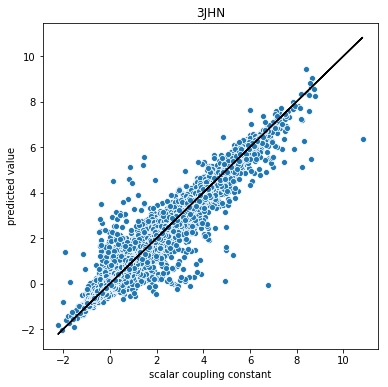

total train LMAE: -1.8380614785287253
total val LMAE -1.1642416499441706


In [16]:
model_dict,scaler_dict=RunByType(train,
                     hidden_units=[128,512,512,128,64,32],dropout=0,lr=0.001,beta1=0.9,beta2=0.999,
                     test_size=0.2,
                     includeType=False,
                     DoCallbacks=True, # end of params, start kwargs
                     batch_size=128, epochs=200, verbose=0,
                     shuffle=True,
                     validation_steps=None, validation_freq=1)

In [17]:
test_predict = PredictByType(test,model_dict,scaler_dict)
test_predict.to_csv('test_predict_TypeModel.csv')

predicting type: 1JHC
predicting type: 1JHN
predicting type: 2JHC
predicting type: 2JHH
predicting type: 2JHN
predicting type: 3JHC
predicting type: 3JHH
predicting type: 3JHN
